In [35]:
%matplotlib inline
import os
import sys
import pathlib
sys.path.append(os.path.join(str(pathlib.Path().resolve()), '../lib'))
from fancy_plot import *
import numpy as np
import pickle
from scipy.optimize import curve_fit
import glob
import pandas as pd
import datetime
import pytz
from tzwhere import tzwhere
import pickle
import copy
from dateutil import parser
from datetime import datetime
from scipy.stats import gaussian_kde
import matplotlib
def to_flxnet_date(time):
    return np.int64('{}{:02d}{:02d}{:02d}{:02d}'.format(time.year, time.month, time.day,
                                                        time.hour,time.minute)) 

def make_prediction_for_site(data, target_key,
                             res_gpp, res_nee):
    spred, targets, tmps_return = None, None, None
    inputs = data['inputs']
    targets = copy.deepcopy(data['flxnet'][target_key].values)
    tmps_return =  [parser.parse(str(i)) for i in data['timestamps']]
    if len(inputs) == 0:
        print('Nothing to plot. continue')
        return None, None, None
    if 'NEE' in target_key:
        spred = -(res_gpp[0][0] * inputs[:,1] * inputs[:,4]  * inputs[:,3]) * inputs[:,0] * inputs[:,2] / (1 + inputs[:,2]/res_gpp[0][1]) + res_nee[0][0] * (inputs[:,5])  + res_nee[0][1]
    else:
        spred = (res_gpp[0][0] * inputs[:,1] * inputs[:,4]  * inputs[:,3]) * inputs[:,0] * inputs[:,2] / (1 + inputs[:,2]/res_gpp[0][1])
        targets[targets<0] = 0
    return spred, targets, tmps_return


def FFP(zm=None, umean=None, h=None, ustar=None):
    """
    Derive a flux footprint estimate based on the simple parameterisation FFP
    See Kljun, N., P. Calanca, M.W. Rotach, H.P. Schmid, 2015: 
    The simple two-dimensional parameterisation for Flux Footprint Predictions FFP.
    Geosci. Model Dev. 8, 3695-3713, doi:10.5194/gmd-8-3695-2015, for details.
    contact: n.kljun@swansea.ac.uk

    FFP Input
    zm		= Measurement height above displacement height (i.e. z-d), i.e. measurement height above trees [m] n 
    umean	= Mean wind speed at zm [m/s]; 
    h		= Boundary layer height [m]
    ustar   = friction velocity [ms-1]

    FFP output
    x_ci_max  = x location of footprint peak (distance from measurement) [m]
    """
    
    import numpy as np
    import sys

    nx = 800
    xstar_end=30
    
    #Model parameters
    b = -1.9914
    c = 1.4622
    d = 0.1359
    #von Karman
    k = 0.4
    xstarmax = -c / b + d
    x_ci_max = xstarmax * zm / (1. - (zm / h)) * (umean / ustar * k)
    return  x_ci_max

site_info = pd.read_csv('/home/b/b309233/software/VPRM_preprocessor/fluxnet_info/site_infos.txt',
                         delimiter=' ')

2023-08-15 21:40:05.327860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 21:40:05.845922: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-15 21:40:05.845952: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-15 21:40:08.075473: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

model.CustomDataGen

In [3]:
# with open('/work/bd1231/tglauch/VPRM_output_modis_new_sites_new/h18v3_2012.pickle', 'rb') as ifile:
#     in1 = pickle.load(ifile)
# in1 = [i[0] for i in in1['DE-Geb']['input_data']]

In [4]:
# with open('/work/bd1231/tglauch/VPRM_output_modis_new_smearing_lowess/h18v3_2012.pickle', 'rb') as ifile:
#     in2 = pickle.load(ifile)

In [5]:
# in2 = [i[0] for i in in2['DE-Geb']['input_data']]
# fig, ax = newfig(0.9)
# ax.plot(range(len(in1)), in1)
# ax.plot(range(len(in2)), in2)
# fig.show()

In [6]:
site_dict = {'grassland': [ 'CH-Cha', 'CH-Fru', 'DE-Gri', 'DE-RuR', 'IT-MBo', 'IT-Tor'], # 'CZ-BK2'  'AT-Neu'
             'mixed_forests': ['BE-Bra', 'BE-Vie', 'CH-Lae'],
             'cropland': [ 'CH-Oe2', 'DE-Geb', 'DE-Kli', 'FR-Gri', 'IT-CA2'], # 'IT-BCi' 'DE-RuS' # 'BE-Lon' problematic site, only works for very small footprints
             'evergeen': ['CZ-BK1', 'DE-Obe', 'DE-Tha', 'FI-Hyy', 'FI-Let', 
                          'IT-Lav', 'IT-Ren',  'NL-Loo'],# 'IT-SRo' 'FI-Sod', 'RU-Fyo' 'DE-Lkb' 'CH-Dav'
           #  'wetland': ['CZ-wet', 'DE-Akm', 'DE-SfN', 'DE-Spw', 'FR-Pue', 'IT-Cp2'],
             'deciduous': ['DE-Hai', 'DE-Lnf', 'DK-Sor', 'FR-Fon', 'IT-CA1', 'IT-Col', 'IT-Ro2'], # 'IT-CA3'
             'shrubland': ['IT-Noe']} # 'ES-Amo''ES-LJu'

veg_type_id = {'grassland': 7, 'mixed_forests': 3 , 'cropland':6, 
               'evergeen': 1, 'deciduous': 2, 'shrubland':4} # 'wetland': 8


In [7]:
# for key in site_dict.keys():
#     for key2 in site_dict[key]:
#         try:
#             mh = float(site_info.loc[site_info['Site_name']==key2]['measurement_height'].values)
#             ch = float(site_info.loc[site_info['Site_name']==key2]['canopy_height'].values)
#             print(key2, mh-ch)
#         except:
#             print(key2)

In [8]:
input_data= {'modis': '/work/bd1231/tglauch/VPRM_output_modis/*_{}.pickle',
             'viirs' : '/work/bd1231/tglauch//VPRM_output_viirs/*_{}.pickle'} 

In [9]:
# test = '/work/bd1231/tglauch/data/FLX_FI-Hyy_FLUXNET2015_FULLSET_1996-2014_1-4/FLX_FI-Hyy_FLUXNET2015_FULLSET_HH_1996-2014_1-4.csv'
# idata = pd.read_csv(test)

In [10]:
# idata

In [11]:
# idata.loc[idata['TIMESTAMP_START']==201205031200]['GPP_DT_VUT_REF']

In [12]:
# plt.hist(FFP(zm=10, umean=idata['WS'], h=1000, ustar=idata['USTAR']), bins=np.linspace(0,500, 200))

In [13]:
# for i in sorted(idata.keys()):
#     print(i)

In [14]:
# ls /work/bd1231/tglauch/data/FLX_CH-Dav_FLUXNET2015_FULLSET_1997-2014_1-4/

In [15]:
# for i in idata['VARIABLE']:
#     if 'FETCH' in i:
#         print(i)

In [16]:
# for i in idata.keys():
#     print(i)

In [17]:
# full_dict['modis']['grassland']['DE-Gri']['flxnet'].keys()

In [18]:
full_dict = dict()
for year in [2012, 2013, 2014]: # , 2013, 2014
    print(year)
    for key in input_data.keys():
        print(key)
        data_dict = dict()
        for cvt, veg_type in enumerate(site_dict.keys()):
            data_dict[veg_type] = dict()
            for f in glob.glob(input_data[key].format(year)):
                with open(f, 'rb') as ifile:
                    idata = pickle.load(ifile)
                for c_site, site in enumerate(site_dict[veg_type]):
                    add_dict = dict()
                    if site not in idata.keys():
                        continue
                    print(site)
                    ipt = np.array(idata[site]['input_data'])
                    flxnet = idata[site]['fluxnet_data']
                    idata[site]['input_data_timestamps'] = np.array([to_flxnet_date(i) for i in idata[site]['input_data_timestamps']])
                    mask1 = [True if i in idata[site]['input_data_timestamps'] else False
                             for i in flxnet['TIMESTAMP_END'].values]
                    mask2 = [True if i in flxnet['TIMESTAMP_END'].values else False
                             for i in idata[site]['input_data_timestamps']]
                    add_dict['flxnet'] = flxnet[mask1]
                    #add_dict['targets_nee'] = np.array(flxnet['NEE_VUT_REF'][mask1].values)
                    add_dict['inputs'] = np.array(ipt[mask2])
                    #add_dict['targets_gpp'] = np.array(flxnet['GPP_DT_VUT_REF'][mask1].values)
                    add_dict['timestamps'] = np.array(idata[site]['input_data_timestamps'][mask2])
                    data_dict[veg_type][site] = add_dict
        if key not in full_dict.keys():
            full_dict[key] = data_dict
        else:
            for veg_type in full_dict[key].keys():
                for site in full_dict[key][veg_type].keys():
                    for arr in full_dict[key][veg_type][site].keys():
                        if site in data_dict[veg_type].keys():
                            to_concat = [full_dict[key][veg_type][site][arr],
                                         data_dict[veg_type][site][arr]]
                            if arr == 'flxnet':
                                full_dict[key][veg_type][site][arr] = pd.concat(to_concat)
                            else:
                                full_dict[key][veg_type][site][arr] = np.concatenate(to_concat)

2012
modis
CH-Cha
CH-Fru
IT-MBo
IT-Tor
DE-Gri
DE-RuR
CH-Lae
BE-Bra
BE-Vie
CH-Oe2
FR-Gri
IT-CA2
DE-Geb
DE-Kli
FI-Hyy
FI-Let
IT-Lav
IT-Ren
DE-Obe
DE-Tha
NL-Loo
CZ-BK1
FR-Fon
IT-CA1
IT-Ro2
DE-Hai
DE-Lnf
DK-Sor
IT-Col
IT-Noe
viirs
CH-Cha
CH-Fru
IT-MBo
IT-Tor
DE-Gri
DE-RuR
CH-Lae
BE-Bra
BE-Vie
CH-Oe2
FR-Gri
IT-CA2
DE-Geb
DE-Kli
FI-Hyy
FI-Let
IT-Lav
IT-Ren
DE-Obe
DE-Tha
NL-Loo
CZ-BK1
FR-Fon
IT-CA1
IT-Ro2
DE-Hai
DE-Lnf
DK-Sor
IT-Col
IT-Noe
2013
modis
DE-Gri
DE-RuR
CH-Cha
CH-Fru
IT-MBo
IT-Tor
BE-Bra
BE-Vie
CH-Lae
DE-Geb
DE-Kli
CH-Oe2
FR-Gri
IT-CA2
CZ-BK1
FI-Hyy
DE-Obe
DE-Tha
NL-Loo
IT-Lav
IT-Ren
IT-Col
DK-Sor
FR-Fon
IT-CA1
IT-Noe
viirs
DE-Gri
DE-RuR
CH-Cha
CH-Fru
IT-MBo
IT-Tor
BE-Bra
BE-Vie
CH-Lae
DE-Geb
DE-Kli
CH-Oe2
FR-Gri
IT-CA2
CZ-BK1
FI-Hyy
DE-Obe
DE-Tha
NL-Loo
IT-Lav
IT-Ren
IT-Col
DK-Sor
FR-Fon
IT-CA1
IT-Noe
2014
modis
CH-Cha
CH-Fru
IT-Tor
DE-Gri
DE-RuR
CH-Lae
BE-Bra
BE-Vie
CH-Oe2
FR-Gri
IT-CA2
DE-Geb
DE-Kli
FI-Hyy
IT-Lav
CZ-BK1
DE-Obe
DE-Tha
NL-Loo
FR-Fon
IT-CA1
IT-Col
DK-Sor
IT-Noe
vii

In [19]:
#Generate Data Masks

mask_dict = dict()
for max_ffp in [100]:
    t_dict = dict()   
    print('-----')

    for cvt, veg_type in enumerate(site_dict.keys()):
        # if cvt>0:
        #     continue
        for site in site_dict[veg_type]:
            print(site)

            this_dict_modis = copy.deepcopy(full_dict['modis'][veg_type][site])
            this_dict_viirs = copy.deepcopy(full_dict['viirs'][veg_type][site])
            print(this_dict_modis['flxnet']['TIMESTAMP_START'][200:203].values,
                  this_dict_viirs['flxnet']['TIMESTAMP_START'][200:203].values)
            try:
                mh = float(site_info.loc[site_info['Site_name']==key2]['measurement_height'].values)
                ch = float(site_info.loc[site_info['Site_name']==key2]['canopy_height'].values)
                zm = mh - ch
            except:
                zm = 10

            this_dict_modis['flxnet']['FFP'] = FFP(zm=zm, umean=this_dict_modis['flxnet']['WS'],
                                                       h=1000, ustar=this_dict_modis['flxnet']['USTAR'])
            mask = (this_dict_modis['flxnet']['NEE_VUT_REF_QC'] <= 1) & (np.abs(this_dict_modis['flxnet']['FFP'])<max_ffp) & (np.isfinite(this_dict_modis['flxnet']['GPP_DT_VUT_REF'])) & np.all(np.isfinite(this_dict_modis['inputs']), axis=1) & np.all(np.isfinite(this_dict_viirs['inputs']), axis=1)
            mask_dict[site] = mask

-----
CH-Cha
[201201090730 201201090830 201201090930] [201201090730 201201090830 201201090930]
CH-Fru
[201201090730 201201090830 201201090930] [201201090730 201201090830 201201090930]
DE-Gri
[201201090730 201201090830 201201090930] [201201090730 201201090830 201201090930]
DE-RuR
[201201090730 201201090830 201201090930] [201201090730 201201090830 201201090930]
IT-MBo
[201201090730 201201090830 201201090930] [201201090730 201201090830 201201090930]
IT-Tor
[201201090730 201201090830 201201090930] [201201090730 201201090830 201201090930]
BE-Bra
[201201090730 201201090830 201201090930] [201201090730 201201090830 201201090930]
BE-Vie
[201201090730 201201090830 201201090930] [201201090730 201201090830 201201090930]
CH-Lae
[201201090730 201201090830 201201090930] [201201090730 201201090830 201201090930]
CH-Oe2
[201201090730 201201090830 201201090930] [201201090730 201201090830 201201090930]
DE-Geb
[201201090730 201201090830 201201090930] [201201090730 201201090830 201201090930]
DE-Kli
[2012010

In [61]:
this_dict_modis['flxnet']['TIMESTAMP_START'][200:203].values

array([201201090730, 201201090830, 201201090930])

In [48]:

plots = False

mse_dict = dict()
for max_ffp in [100]:
    fit_params = dict()
    res_dict = dict()
    for key in input_data.keys():
        t_dict = dict()   
        print('-----')

        temp_dict = dict()
        mse_sub_dict = dict()

        for cvt, veg_type in enumerate(site_dict.keys()):
            # if cvt>0:
            #     continue
            print(veg_type)
            targets_gpp,  targets_nee, inputs = [], [], []
            lens = [0]
            len0 = 0

    # -------------------------- Read Data -------------------------------- 


            for site in site_dict[veg_type]:
                #print(site)

                this_dict = copy.deepcopy(full_dict[key][veg_type][site])
                mask = mask_dict[site]
                this_dict['inputs'][:,2] = this_dict['flxnet']['SW_IN_F'] / 0.505
                targets_nee.extend(copy.deepcopy(this_dict['flxnet']['NEE_VUT_REF'].values)[mask])
                inputs.extend(this_dict['inputs'][mask])
                targets_gpp.extend(copy.deepcopy(this_dict['flxnet']['GPP_DT_VUT_REF'].values)[mask])
                lens.append(len(targets_gpp)-len0)
                len0 = len(targets_gpp)


            # Prepare Data
            inds = []
            lens = np.array(lens)
            targets_nee = np.array(targets_nee)
            targets_gpp = np.array(targets_gpp)
            inputs = np.array(inputs)

            if np.sum(lens) == 0:
                continue
            num_inds_per_site = np.min(lens[lens>0])
            cum_len = np.cumsum(lens)
            for i in range(len(cum_len)-1):
                if cum_len[i] == cum_len[i+1]:
                    continue
                np.random.seed(10)
                t_inds = np.random.choice(np.arange(cum_len[i], cum_len[i+1]),
                                          num_inds_per_site)
                inds.append(t_inds)

            inds = np.concatenate(inds)  
            inputs = inputs[inds]
            targets_gpp = targets_gpp[inds]
            targets_nee = targets_nee[inds]
            # mask = targets_gpp > 0.0
            # mask_nan = np.all(np.isfinite(inputs), axis=1)
            mse_min = 1e4

            print(len(targets_gpp))
            #Make Fits
            for i in range(5):
#                 res_gpp_test = curve_fit(lambda x, lamb, par0, topt: np.maximum((lamb * x[:,1] * x[:,4]  * (((x[:,5] - 0) * (x[:,5] - 40)) / ((x[:,5]-0)*(x[:,5]-40) - (x[:,5] - topt)**2))) * x[:,0] * x[:,2] / (1 + x[:,2]/par0), 0 ),
#                                         inputs, targets_gpp, maxfev=5000, p0=[np.random.uniform(0,1), np.random.uniform(0,1), 20]) 
                
#                 print(res_gpp_test)
                res_gpp_t = curve_fit(lambda x, lamb, par0: (lamb * x[:,1] * x[:,4]  * x[:,3]) * x[:,0] * x[:,2] / (1 + x[:,2]/par0),
                                inputs, targets_gpp, maxfev=5000, p0=[np.random.uniform(0,1), np.random.uniform(0,1)]) 

                spred = (res_gpp_t[0][0] * inputs[:,1] * inputs[:,4]  * inputs[:,3]) * inputs[:,0] * inputs[:,2] / (1 + inputs[:,2]/res_gpp_t[0][1])

                mse = (np.square(targets_gpp - spred)).mean()
                if mse < mse_min:
                    res_gpp = res_gpp_t
                    mse_min = mse

            print('MSE GPP:', mse_min)
            mse_min = 1e4

            for i in range(5):

                res_nee_t = curve_fit(lambda x, a,b : -(res_gpp[0][0] * x[:,1] * x[:,4]  * x[:,3]) * x[:,0] * x[:,2] / (1 + x[:,2]/res_gpp[0][1]) + a * x[:,5] + b,
                                inputs, targets_nee, maxfev=5000, p0=[np.random.uniform(0,1), np.random.uniform(0,1)])  

                spred = -(res_gpp[0][0] * inputs[:,1] * inputs[:,4]  * inputs[:,3]) * inputs[:,0] * inputs[:,2] / (1 + inputs[:,2]/res_gpp[0][1]) + res_nee_t[0][0] * (inputs[:,5])  + res_nee_t[0][1]

                mse = (np.square(targets_nee - spred)).mean()

                if mse < mse_min:
                    res_nee = res_nee_t
                    mse_min = mse
            mse_sub_dict[veg_type] = [mse, len(targets_nee), np.mean(targets_gpp)]

            print('MSE NEE:', mse_min)
            temp_dict[veg_type_id[veg_type]] = [res_gpp, res_nee]

          #  print('Make plots')
            target_key  = 'GPP_DT_VUT_REF'# 'GPP_DT_VUT_REF' #  #'GPP_DT_VUT_REF' #

    # -------------------------- Plots for Cross-Checks --------------------------------  

            for site in site_dict[veg_type]:

                try:
                    this_dict = copy.deepcopy(full_dict[key][veg_type][site])
                    mask = (this_dict['flxnet']['NEE_VUT_REF_QC'] <= 1) & (np.isfinite(this_dict['flxnet']['GPP_DT_VUT_REF'])) & np.all(np.isfinite(this_dict['inputs']), axis=1)
                except:
                    continue
                this_dict['flxnet']['FFP'] = FFP(zm=10, umean=this_dict['flxnet']['WS'],
                                                 h=1000, ustar=this_dict['flxnet']['USTAR'])
           #     this_dict['inputs'][:,2] = this_dict['flxnet']['SW_IN_F'] / 0.505
                ws_mask = np.abs(this_dict['flxnet']['FFP'])<10
                spred, targets, tmsp = make_prediction_for_site(this_dict, target_key, res_gpp, res_nee)
                print(site, len(spred), np.sum(spred[mask]))
                if spred is None:
                    continue
                ax_max = np.max([spred[np.isfinite(spred)], targets[np.isfinite(spred)]])
                ax_min = np.min([spred[np.isfinite(spred)], targets[np.isfinite(spred)]])
                t_dict[site] = [spred[mask], targets[mask], np.array(tmsp)[mask]]
                if plots:
                # Plot 1
                    fig = plt.figure(figsize=figsize(2.0, ratio=0.3))#newfig(1.2,ratio=0.3)
                    ax = fig.add_axes((0.0, 0.0, 0.3, 1.0))
                    xy = np.vstack([targets[mask], spred[mask]])
                    z = gaussian_kde(xy)(xy)
                    ax.scatter(targets[mask], spred[mask], s=3, c=z)
                 #   ax.scatter(targets[mask & ws_mask], spred[mask & ws_mask], s=3, color='red')
                    ax.set_xlabel('Target')
                    ax.set_ylabel('Prediction')
                    ax.text(0.02, 0.98, '{} ({}, {})'.format(site, veg_type, key),
                      horizontalalignment='left',
                      verticalalignment='top',
                      transform = ax.transAxes)
                    ax.plot([ax_min, ax_max], [ax_min, ax_max], color='k',
                         lw=2)

                    month_values_pred = []
                    temp_values_pred = [] 
                    month_values_truth = []
                    temp_values_truth = [] 
                    c_month = tmsp[0].month
                    for c, i in enumerate(tmsp):
                        if i.month != c_month:
                            c_month = i.month
                            # print(site, i.month, len(temp_values_pred), np.mean(temp_values_pred))
                            month_values_pred.append(np.sum(np.array(temp_values_pred)[np.isfinite(temp_values_pred)]))
                            month_values_truth.append(np.sum(np.array(temp_values_truth)[np.isfinite(temp_values_pred)]))
                            temp_values_truth = [] 
                            temp_values_pred = []
                        temp_values_pred.append(spred[c])
                        temp_values_truth.append(targets[c])

                    ax2 = fig.add_axes((0.4, 0.0, 0.6, 1.0))
                    ax2.plot(range(len(month_values_truth)), month_values_truth, color='k',
                         marker='o', label='FLUXNET')
                    ax2.plot(range(len(month_values_pred)), month_values_pred, color='b',
                     marker='o', label='Estimation')
                    ax2.legend(loc='best', frameon=False)
                    ax2.set_ylabel('Tot. NEE')
                    ax2.set_xlabel('Month Count')
                    fig.show()
                    print(np.sum(month_values_truth), np.sum(month_values_pred), (np.sum(month_values_truth)-np.sum(month_values_pred))/np.sum(month_values_pred))

                    fig.savefig('/work/bd1231/tglauch/plots/{}_{}.jpg'.format(key, site), dpi=300,
                                bbox_inches='tight')

                    # # Plot 2
                    # fig, ax = newfig(2.0, ratio=0.3)
                    # ax.plot(range(len(targets)), targets, lw=1, color='k',
                    #      marker='o', ms=1)
                    # ax.plot(range(len(spred)), spred, lw=1,
                    #      marker='o', ms=1)
                    # ax.text(0.1, 0.9, site,
                    #   horizontalalignment='left',
                    #   verticalalignment='top',
                    # transform = ax.transAxes)
                    # ax.set_xlim(3000,3500)
                    # fig.show()


            res_dict[key] = t_dict
        fit_params[key] = temp_dict
    mse_dict[max_ffp] = mse_sub_dict

-----
grassland
95982
MSE GPP: 12.69134662942561
MSE NEE: 16.64270137589782
CH-Cha 26307 130489.12734799202
CH-Fru 26307 112798.78414971216
DE-Gri 26307 107695.13370737813
DE-RuR 26307 134445.34495024988
IT-MBo 17546 54740.80549573289
IT-Tor 26307 51256.54927454812
mixed_forests
67329
MSE GPP: 8.958312203179663
MSE NEE: 19.70522325680194
BE-Bra 26307 103499.08497360405
BE-Vie 26307 90601.2456540156
CH-Lae 26307 134585.72923272947
cropland
101985
MSE GPP: 16.58238868792398
MSE NEE: 16.142374660324272
CH-Oe2 26307 83642.00727156718
DE-Geb 26307 66629.79861255761
DE-Kli 26307 52454.29011814111
FR-Gri 26307 53400.78523869058
IT-CA2 26307 79261.08425810254
evergeen
62944
MSE GPP: 6.257972020418688
MSE NEE: 10.828114752830947
CZ-BK1 26307 120811.47480260488
DE-Obe 26307 104609.07381363321
DE-Tha 26307 143480.3131780017
FI-Hyy 26307 80424.64118799723
FI-Let 8785 34247.33452691905
IT-Lav 26307 120677.61897001813
IT-Ren 17546 57488.07494894
NL-Loo 26307 129917.12402208755
deciduous
47726
MSE GP

In [20]:
# fit_params

In [20]:
# for k in ['modis', 'viirs']:
#     o_dict = dict()
#     for vkey in sorted(fit_params[k]):
#         o_dict[vkey] = dict(zip(['lamb', 'par0', 'alpha', 'beta'], list(np.concatenate([fit_params[k][vkey][0][0], fit_params[k][vkey][1][0]]))))
#     with open('/home/b/b309233/{}.pickle'.format(k), 'w+b') as ofile:
#         pickle.dump(o_dict, ofile)
#     print(o_dict)

{1: {'lamb': 0.20063717101161435, 'par0': 468.8048287341131, 'alpha': 0.2884862990387428, 'beta': 0.167070491978195}, 2: {'lamb': 0.14658071094239392, 'par0': 385.79708025551355, 'alpha': 0.1698912058348223, 'beta': 1.106014180848722}, 3: {'lamb': 0.15970354387458238, 'par0': 428.00646697933536, 'alpha': 0.27747212129260174, 'beta': 0.16431511509930108}, 4: {'lamb': 0.10780882249463965, 'par0': 696.9092386231259, 'alpha': 0.09813993229106188, 'beta': -0.17308328873253823}, 6: {'lamb': 0.10643320534388134, 'par0': 635.7982653665051, 'alpha': 0.284652148629195, 'beta': -0.8755443410234901}, 7: {'lamb': 0.1449486343041492, 'par0': 485.6735996708087, 'alpha': 0.4530609692530774, 'beta': -0.4264990782644964}}
{1: {'lamb': 0.21985883031993206, 'par0': 427.69328272380045, 'alpha': 0.29184642656515697, 'beta': 0.06614997500557585}, 2: {'lamb': 0.1423280527023211, 'par0': 372.6472237942237, 'alpha': 0.1795664217220013, 'beta': 0.9845439325501817}, 3: {'lamb': 0.1615313841905294, 'par0': 416.544

In [21]:
# for k in ['modis', 'viirs']:
#     o_dict = dict()
#     for vkey in sorted(fit_params[k]):
#         o_dict[vkey] = dict(zip(['lamb', 'par0', 'alpha', 'beta'], list(np.concatenate([fit_params[k][vkey][0][0], fit_params[k][vkey][1][0]]))))
#     with open('/home/b/b309233/{}.pickle'.format(k), 'w+b') as ofile:
#         pickle.dump(o_dict, ofile)
#     print(o_dict)

In [21]:
with open('/home/b/b309233/modis.pickle', 'rb') as ifile:
    test = pickle.load(ifile)
for k in test.keys():
    print(k, ' & {:.2f} & {:.2f} & {:.2f} &  {:.2f} '.format(test[k]['lamb'], test[k]['par0'], test[k]['alpha'], test[k]['beta']))

1  & 0.20 & 468.80 & 0.29 &  0.17 
2  & 0.15 & 385.80 & 0.17 &  1.11 
3  & 0.16 & 428.01 & 0.28 &  0.16 
4  & 0.11 & 696.91 & 0.10 &  -0.17 
6  & 0.11 & 635.80 & 0.28 &  -0.88 
7  & 0.14 & 485.67 & 0.45 &  -0.43 


In [23]:
with open('/home/b/b309233/viirs.pickle', 'rb') as ifile:
    test = pickle.load(ifile)
for k in test.keys():
    print(k, ' & {:.2f} & {:.2f} & {:.2f} &  {:.2f} '.format(test[k]['lamb'], test[k]['par0'], test[k]['alpha'], test[k]['beta']))

1  & 0.22 & 427.69 & 0.29 &  0.07 
2  & 0.14 & 372.65 & 0.18 &  0.98 
3  & 0.16 & 416.54 & 0.27 &  0.15 
4  & 0.13 & 349.46 & 0.13 &  -0.57 
6  & 0.11 & 599.18 & 0.29 &  -0.91 
7  & 0.16 & 458.74 & 0.46 &  -0.48 


CH-Cha


/tmp/ipykernel_53814/4088516774.py:99: RuntimeWarning: invalid value encountered in divide
  ax3.hist((res_dict['viirs'][key][0][inds1] - res_dict['modis'][key][0][inds2])/res_dict['viirs'][key][0][inds1]*100,


CH-Fru
DE-Gri
DE-RuR
IT-MBo
IT-Tor
BE-Bra
BE-Vie
CH-Lae
CH-Oe2
DE-Geb


/tmp/ipykernel_53814/4088516774.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize(2.0, ratio=0.3))


DE-Kli
FR-Gri
IT-CA2
CZ-BK1
DE-Obe
DE-Tha
FI-Hyy
FI-Let
IT-Lav
IT-Ren
NL-Loo
DE-Hai
DE-Lnf
DK-Sor
FR-Fon
IT-CA1
IT-Col
IT-Ro2
IT-Noe


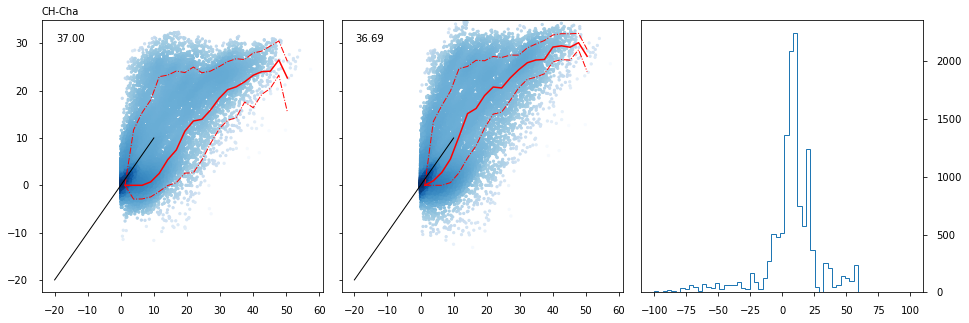

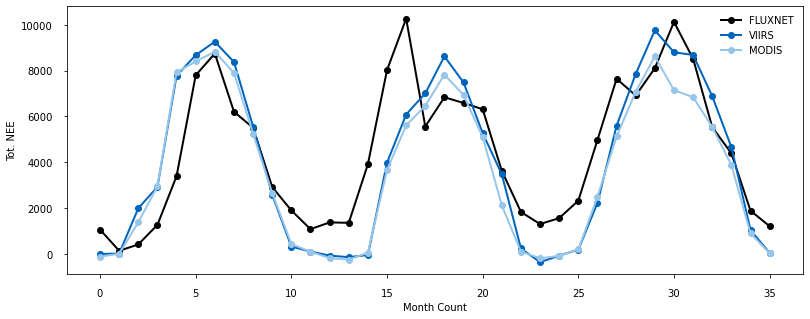

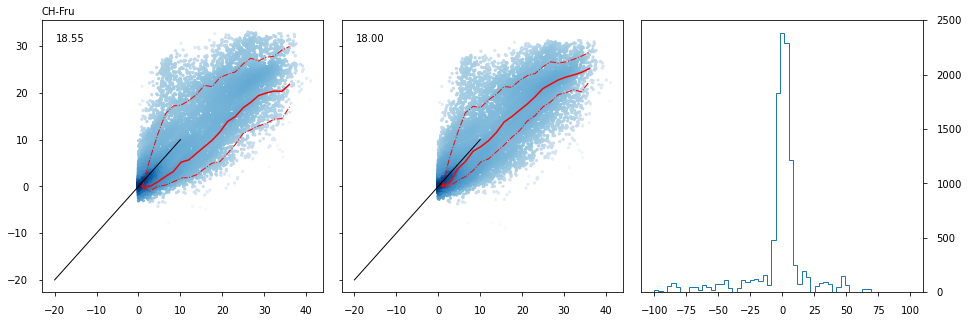

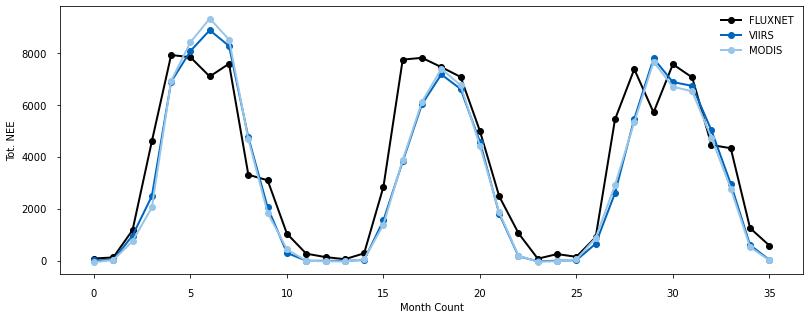

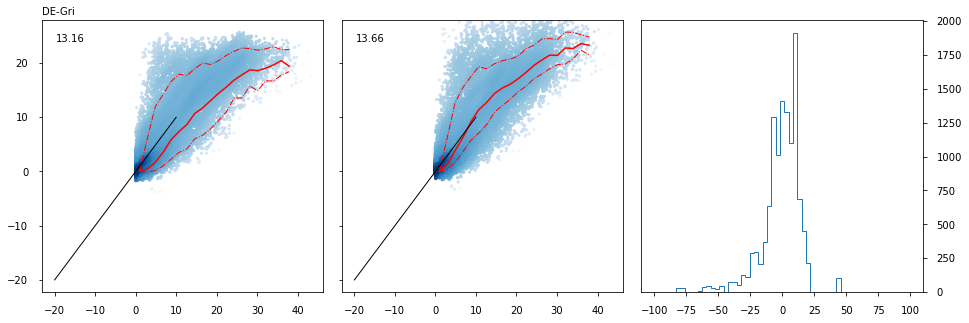

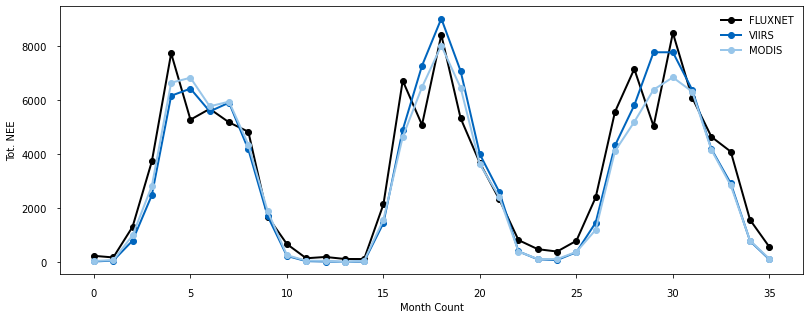

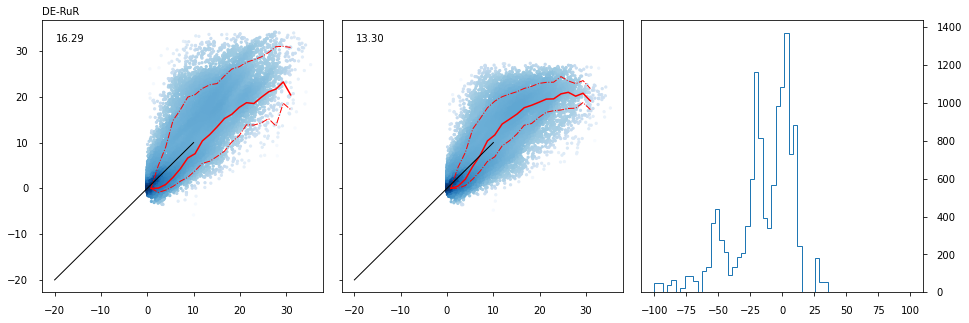

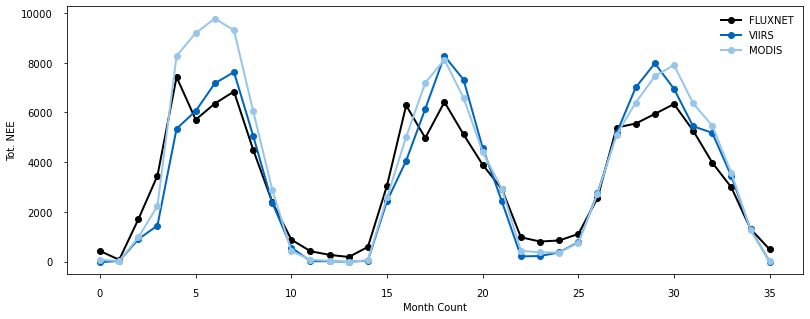

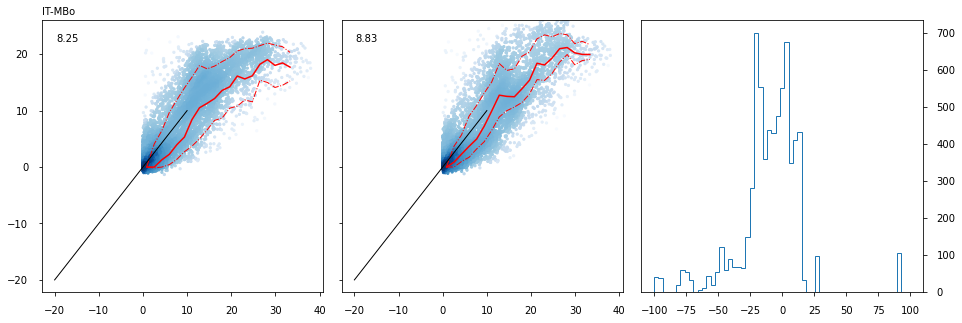

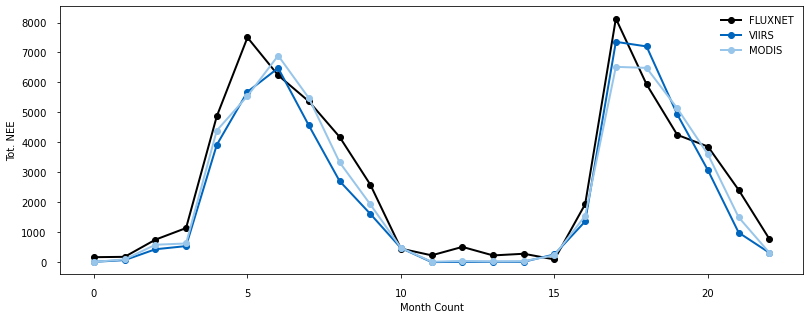

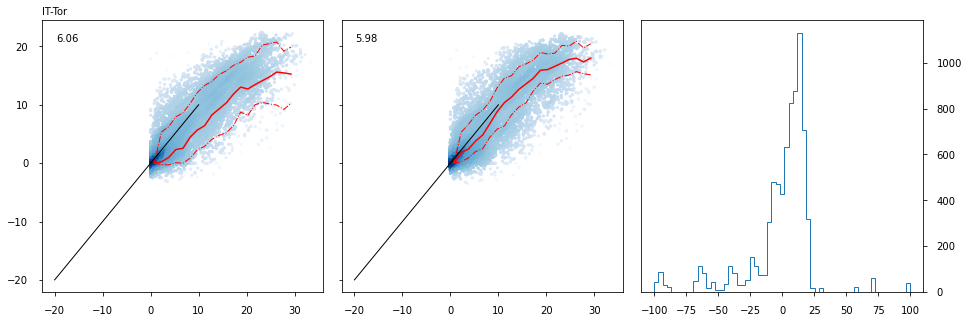

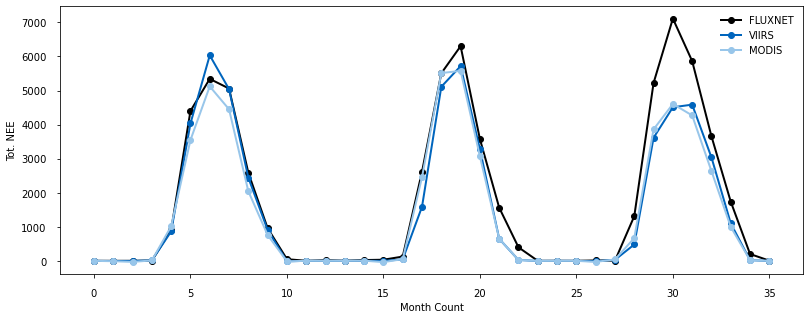

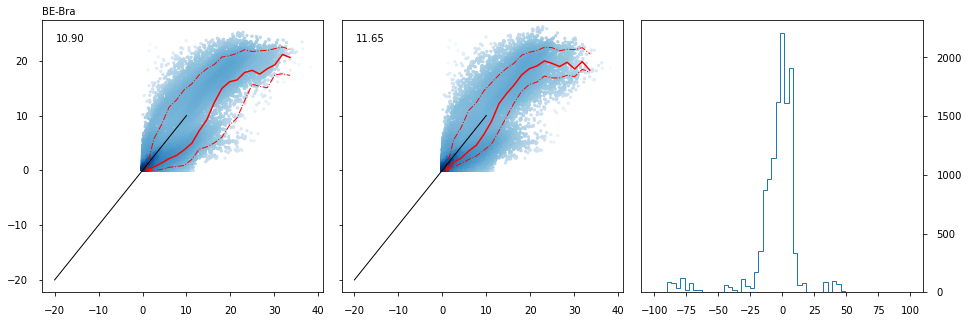

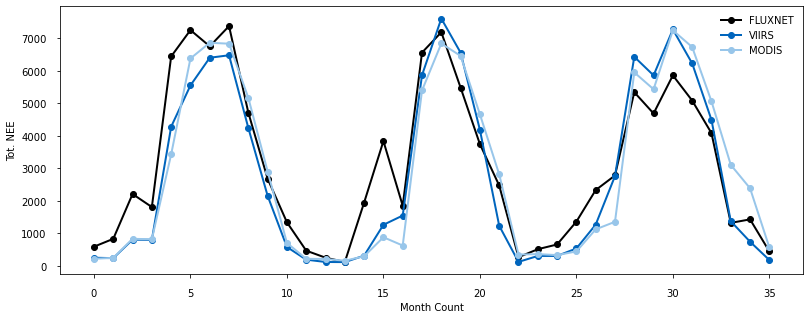

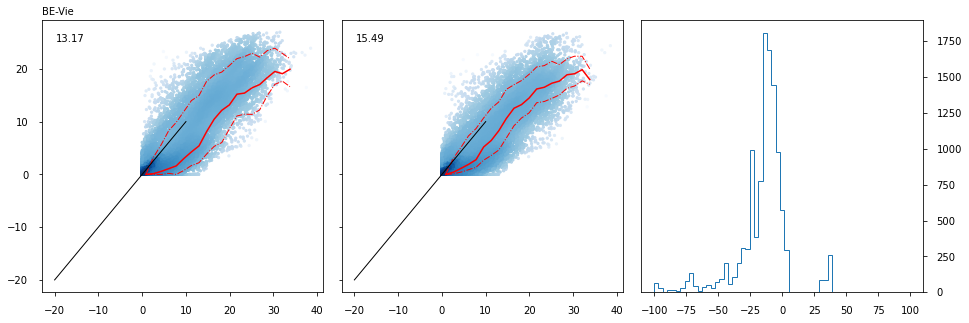

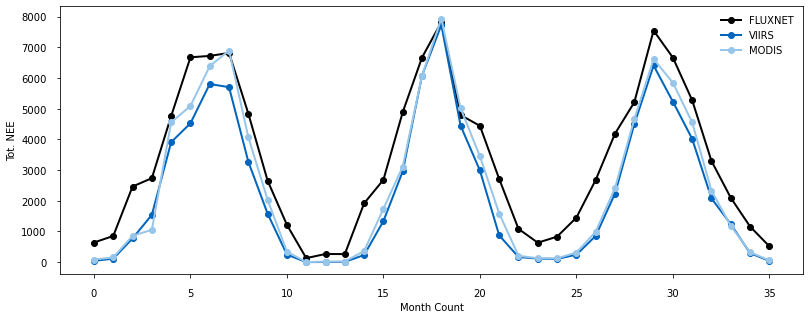

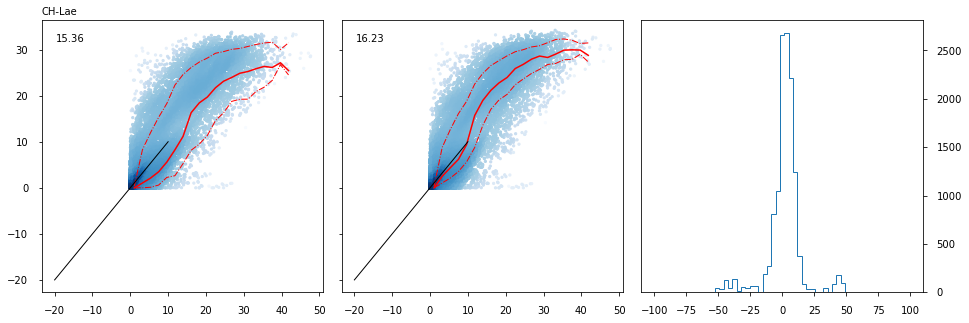

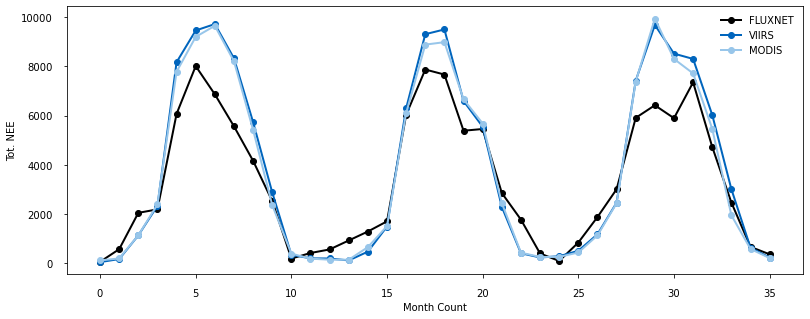

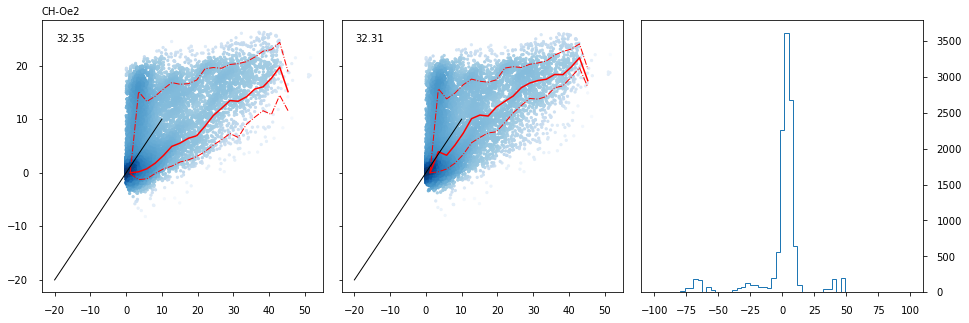

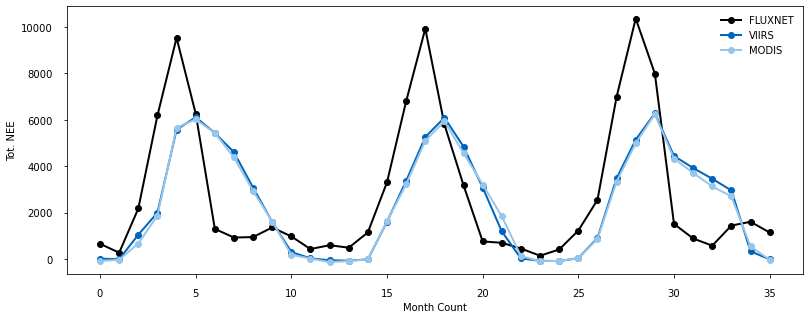

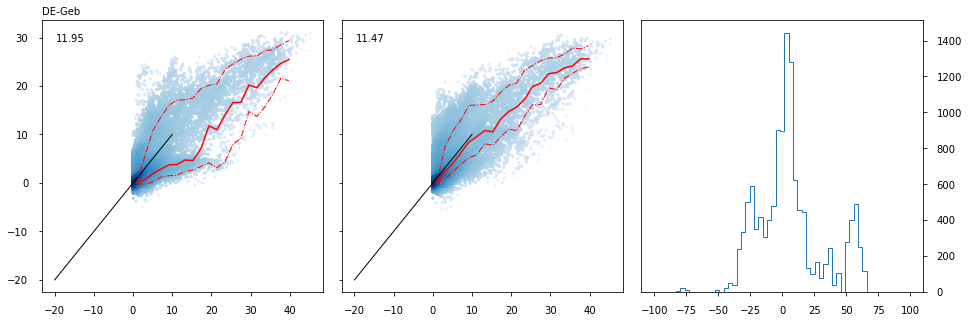

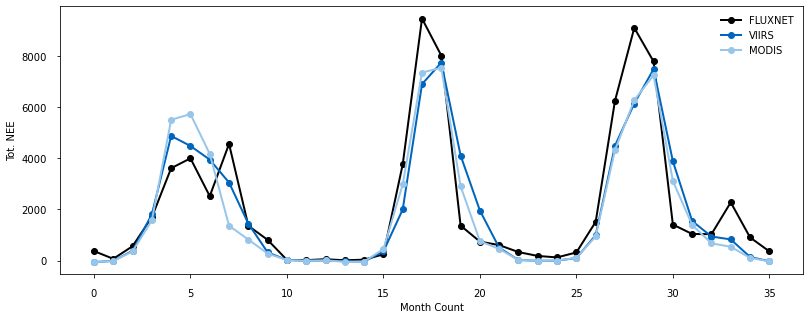

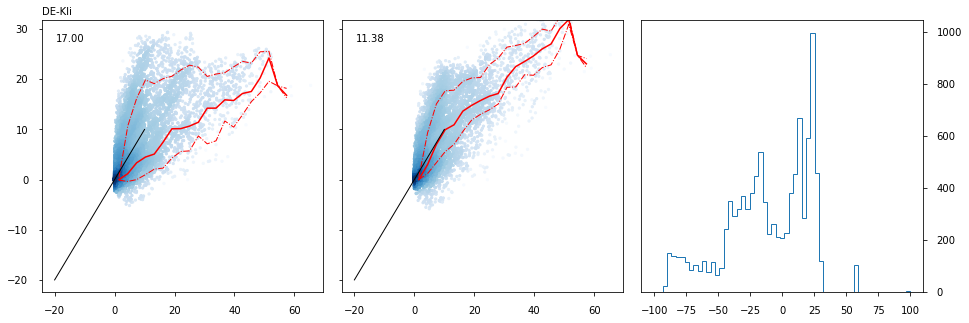

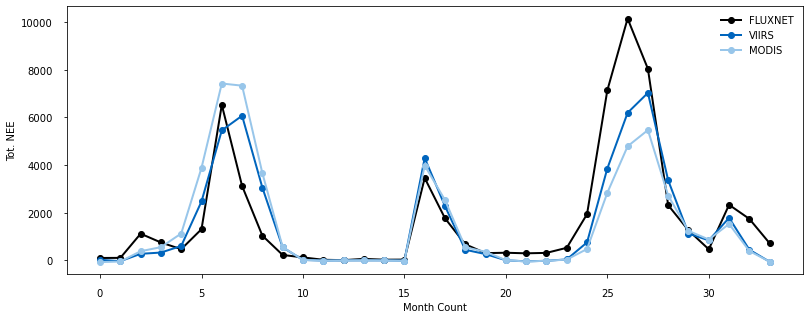

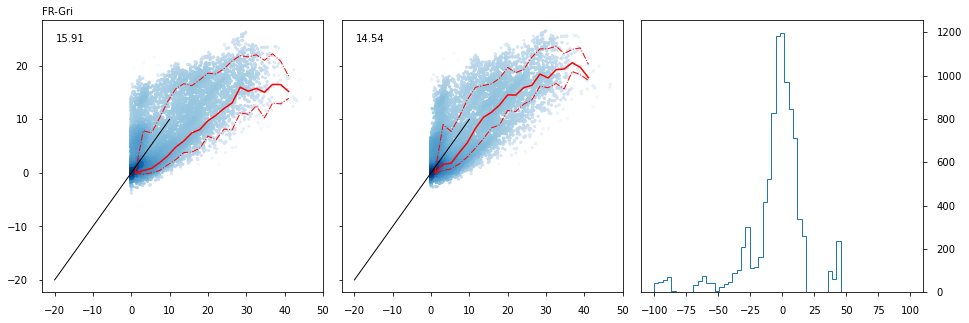

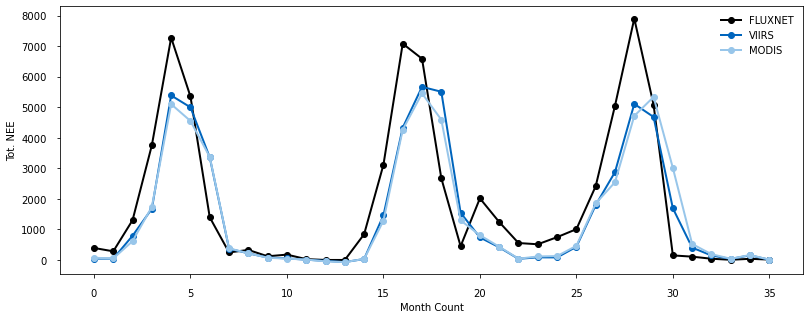

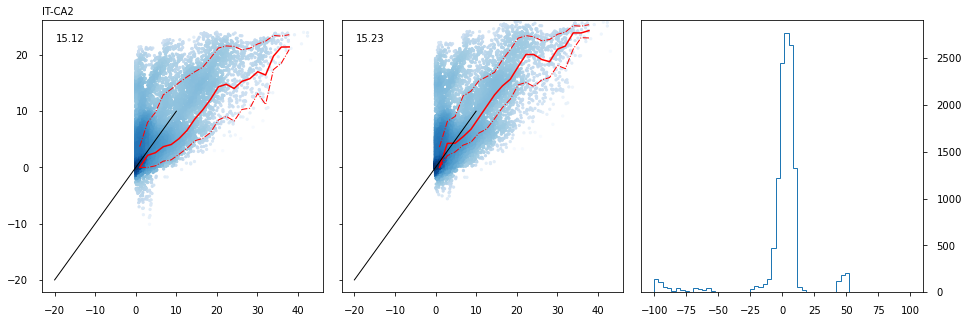

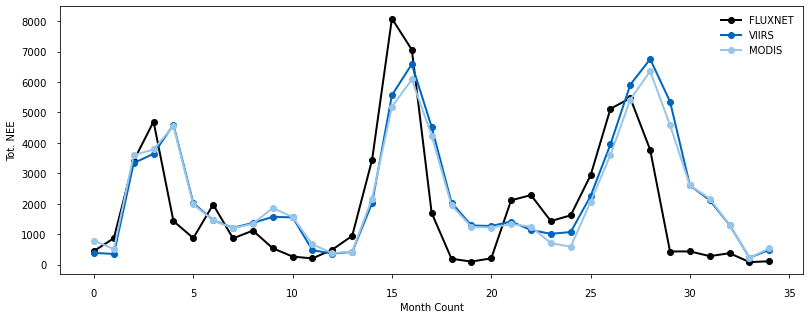

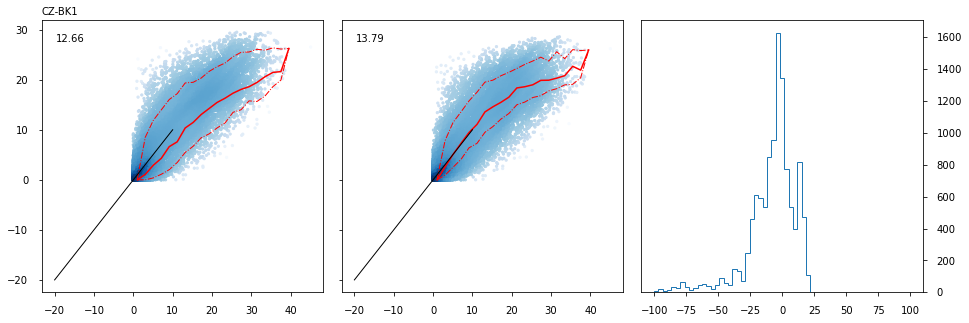

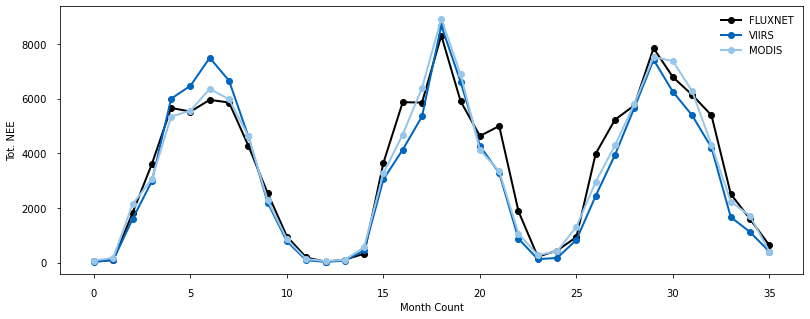

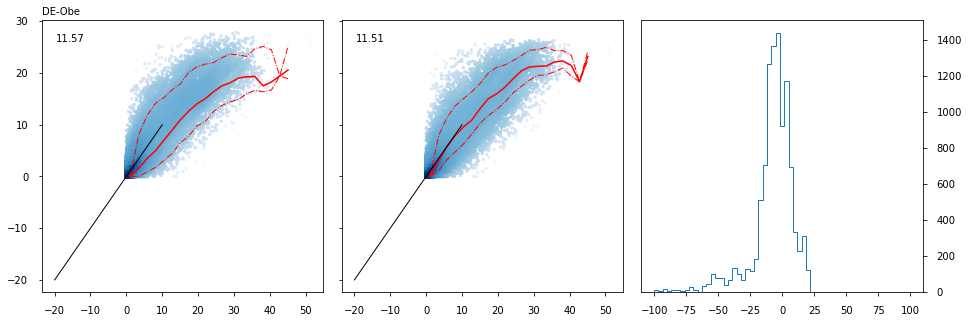

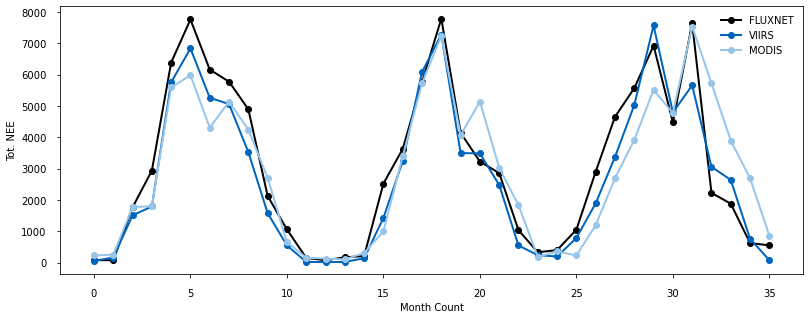

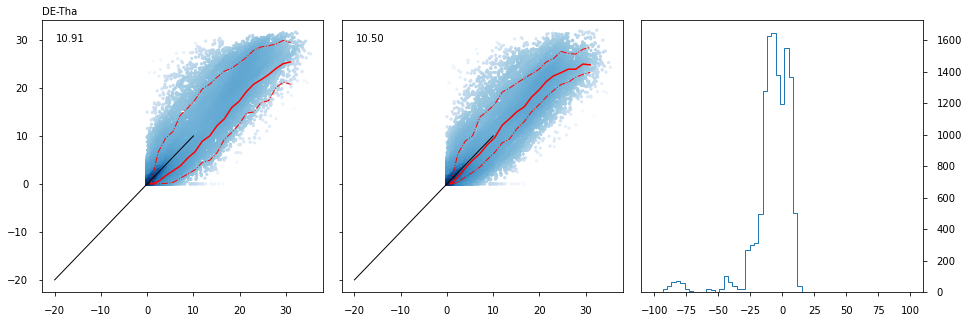

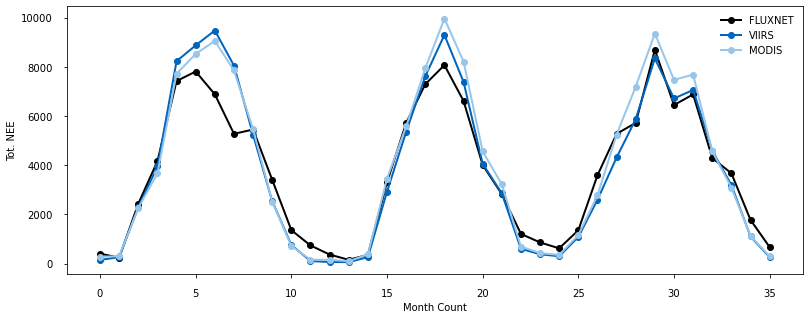

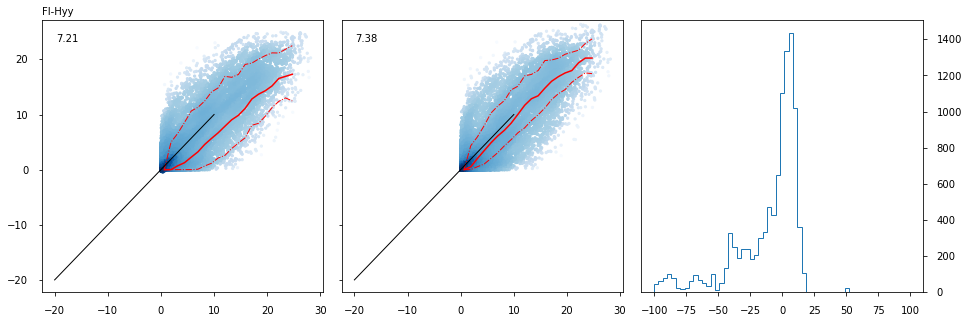

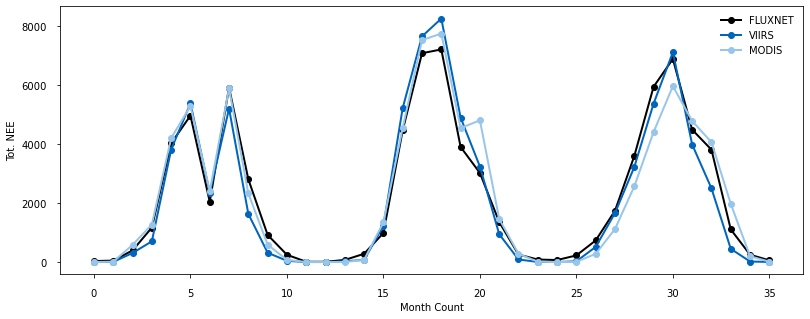

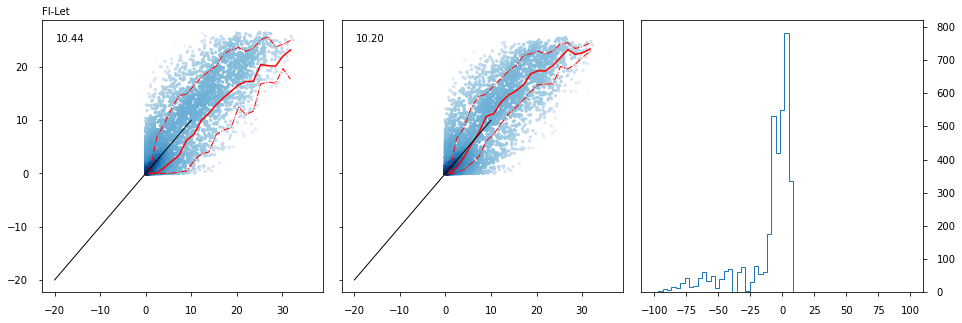

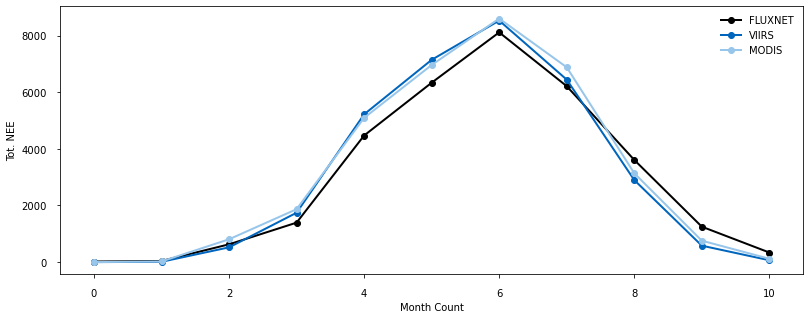

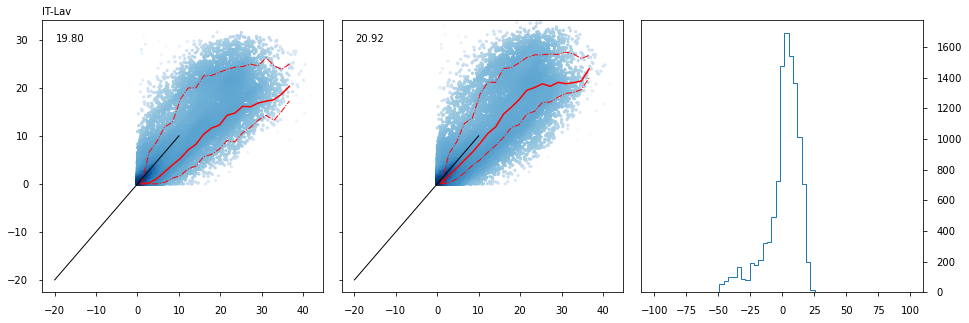

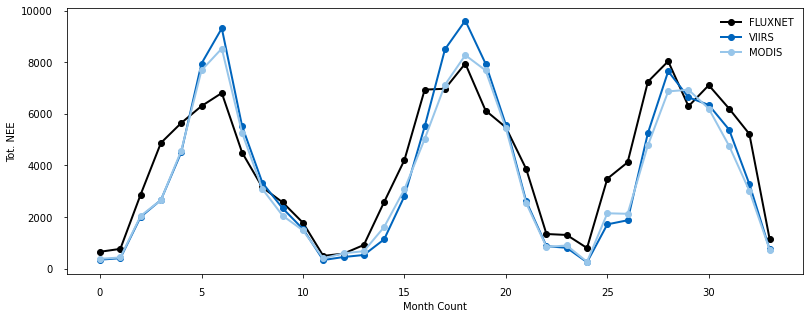

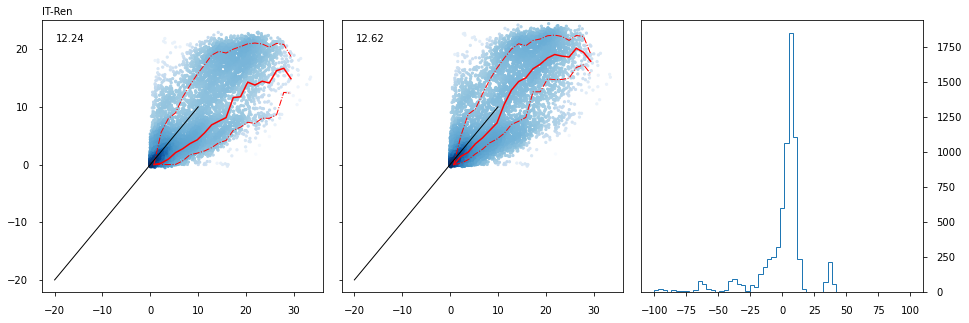

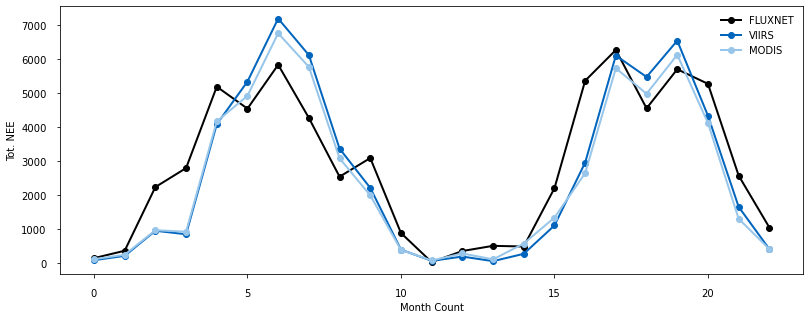

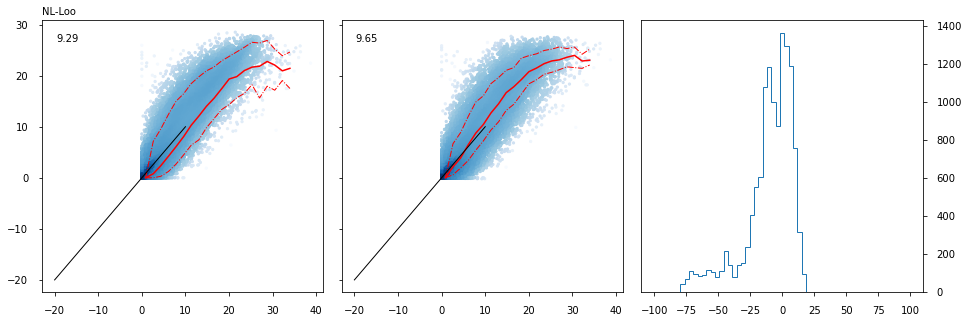

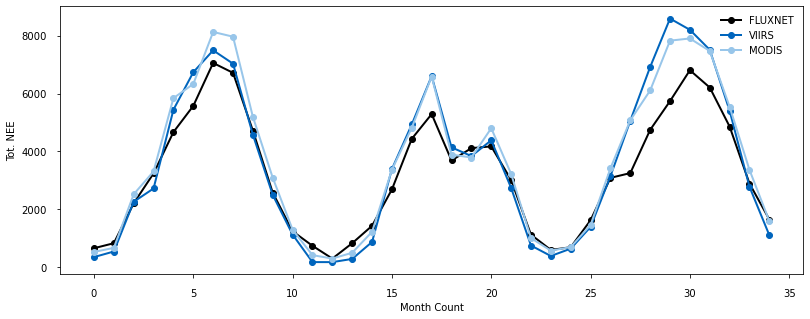

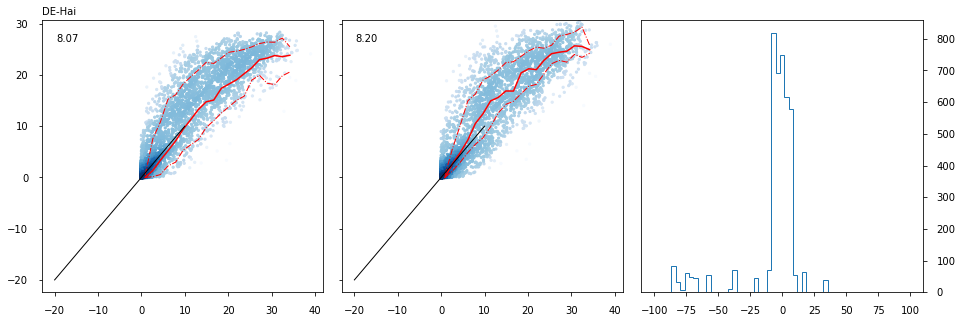

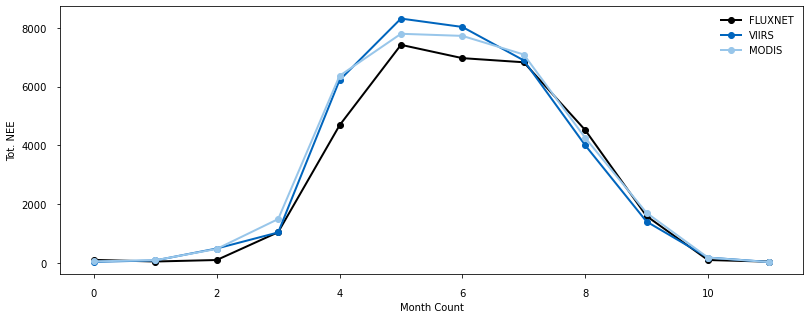

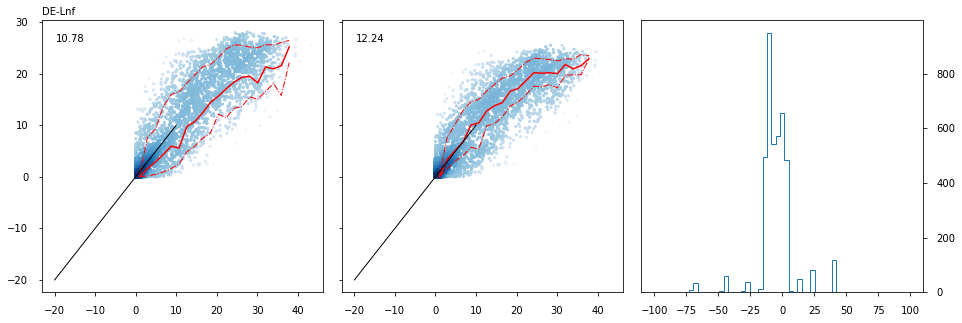

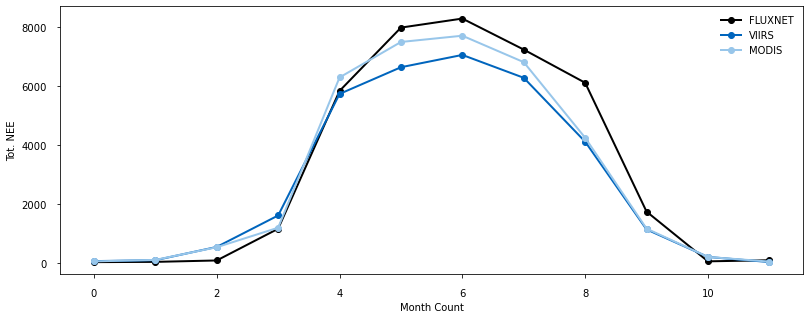

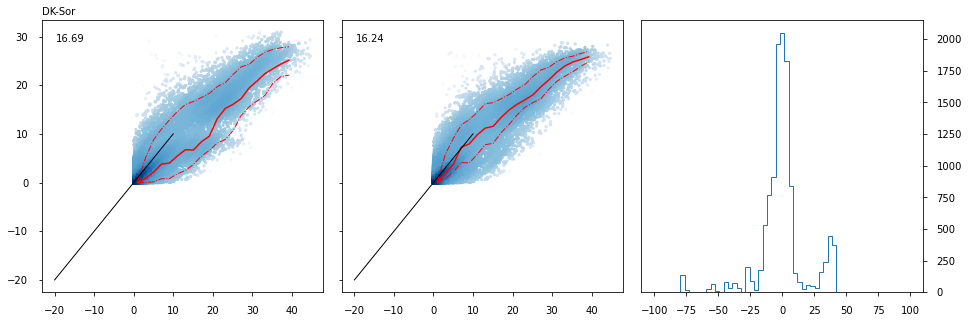

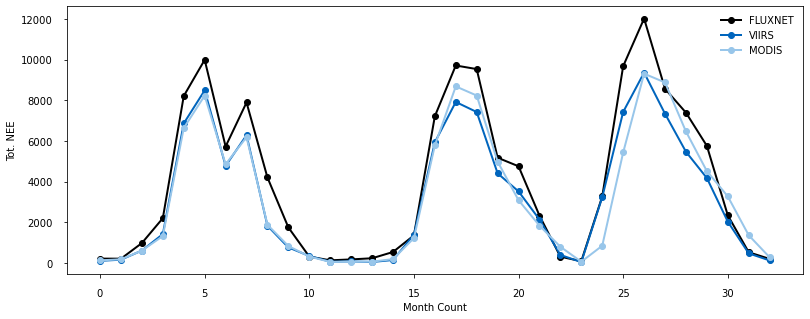

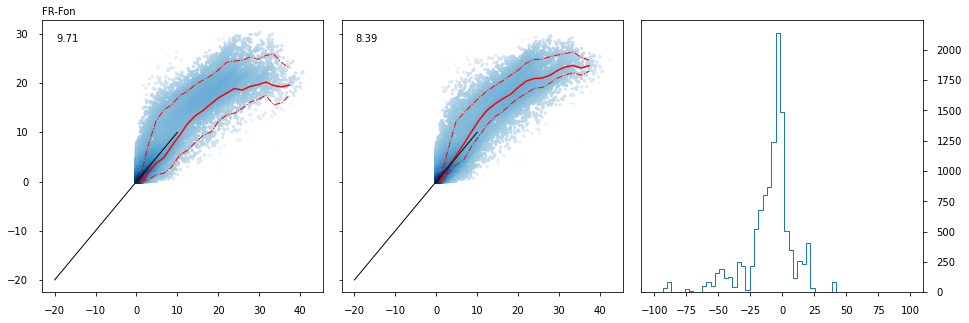

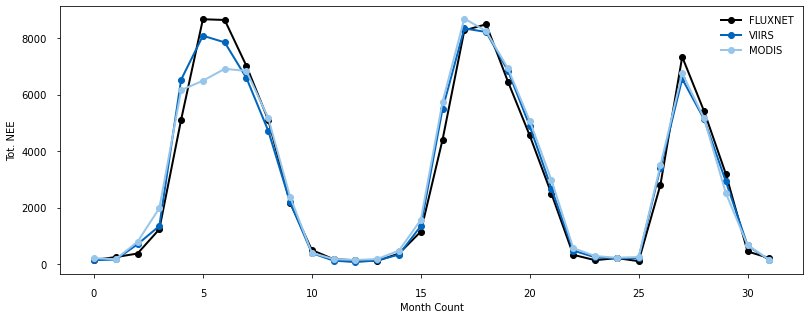

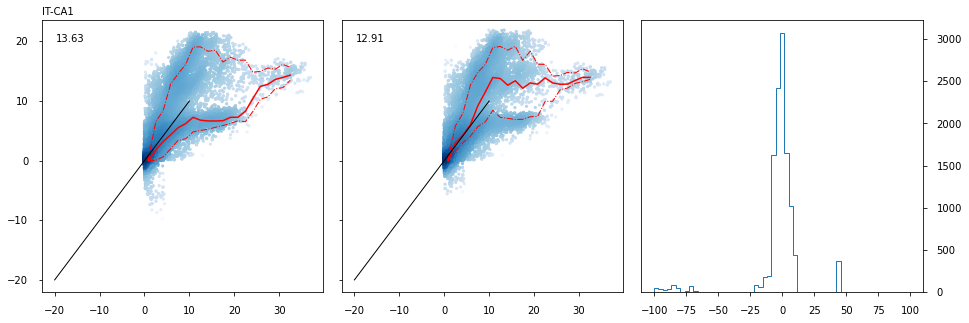

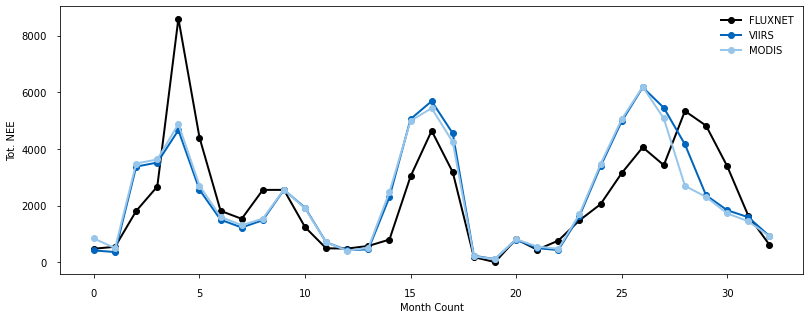

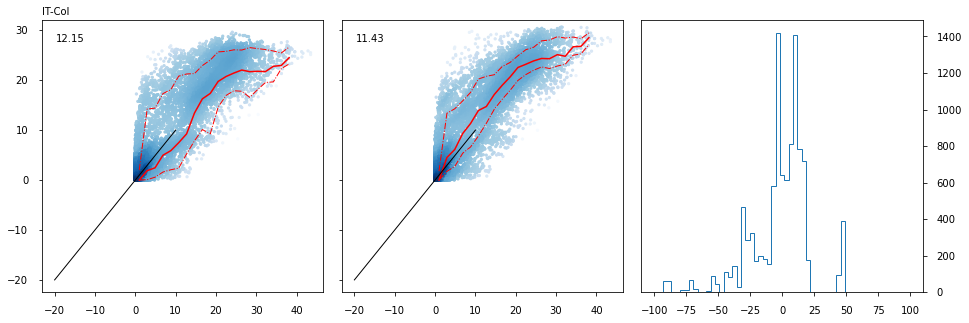

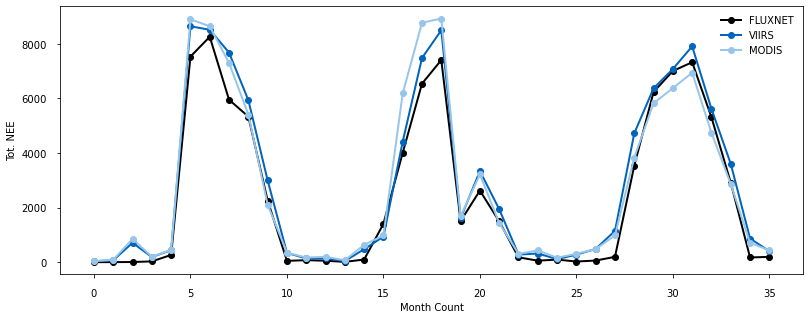

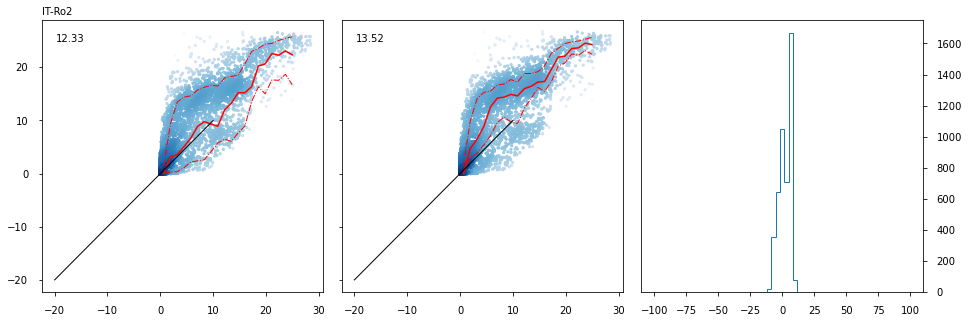

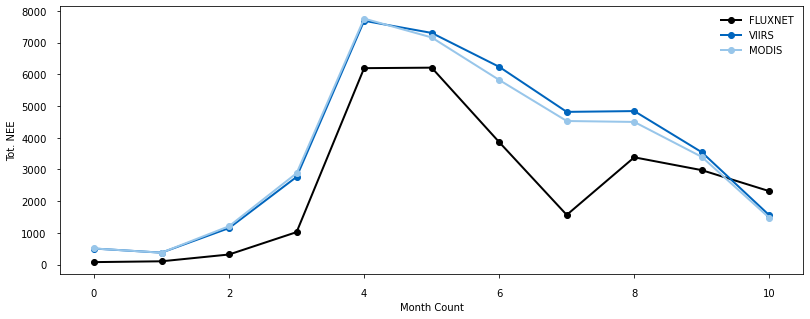

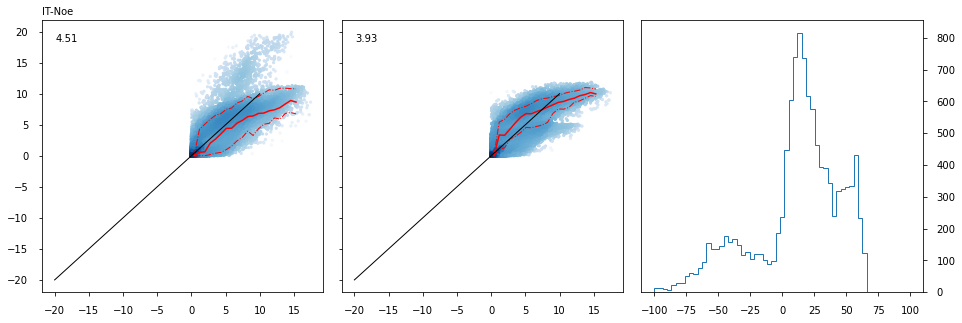

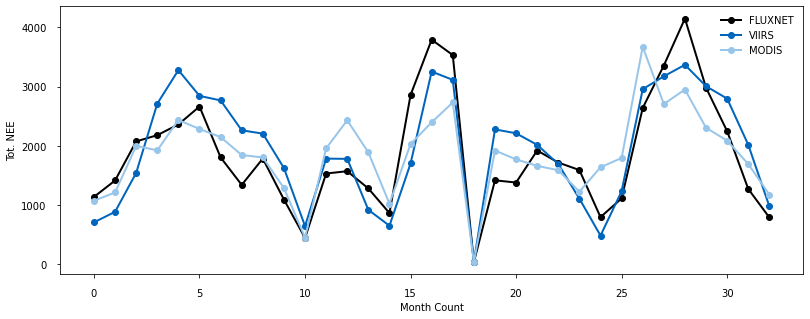

In [61]:
for l, key in enumerate(res_dict['modis'].keys()):
    # if l>5:
    #     continue
    print(key)
    inds1 = []
    inds2 = []
    for c, t in enumerate(res_dict['viirs'][key][2]):
        ti = np.where(t==res_dict['modis'][key][2])[0]
        if len(ti)>0:
            inds1.append(c)
    for c, t in enumerate(res_dict['modis'][key][2]):
        ti = np.where(t==res_dict['viirs'][key][2])[0]
        if len(ti)>0:
            inds2.append(c)
            
# ----------------- MODIS ---------------------------------------        
            
    fig = plt.figure(figsize=figsize(2.0, ratio=0.3))
    ax1 = fig.add_axes((0.,0, 0.31, 1.0))
    ax2 = fig.add_axes((0.33,0, 0.31, 1.0))
    ax3 = fig.add_axes((0.66,0, 0.31, 1.0))
    xy = np.vstack([res_dict['modis'][key][1][inds2],
                    res_dict['modis'][key][0][inds2]])
    z = gaussian_kde(xy)(xy)
    ax1.scatter(res_dict['modis'][key][1][inds2],
                res_dict['modis'][key][0][inds2],
                c=z, s=5, cmap='Blues', norm=matplotlib.colors.LogNorm())
    
    plt_dict = {r'95': [],
                r'5': [],
                r'50': [],
                r'84': [],
                r'26': [],            
                'bins': []}

    bins_y = np.linspace(np.min(res_dict['modis'][key][0][inds2]),
                         np.max(res_dict['modis'][key][0][inds2]), 21)
    bins_x = np.linspace(np.min(res_dict['modis'][key][1][inds2]),
                         0.9 * np.max(res_dict['modis'][key][1][inds2]), 21)
    for i in range(len(bins_x)-1):
        temp_mask = (res_dict['modis'][key][1][inds2]>=bins_x[i]) & (res_dict['modis'][key][1][inds2]<bins_x[i+1])
        temp_df = res_dict['modis'][key][0][inds2][temp_mask]
    #     print(len(temp_df))
        if len(temp_df) == 0:
            continue
        for q_key in plt_dict.keys():
            if q_key == 'bins':
                plt_dict['bins'].append((bins_x[i]+bins_x[i+1])/2)
                continue
            plt_dict[q_key].append(np.percentile(temp_df, float(q_key)))
                   
    ax1.plot(plt_dict['bins'], plt_dict['26'], color='red', lw=1.5)
    ax1.plot(plt_dict['bins'], plt_dict['5'], color='red', ls='-.')
    ax1.plot(plt_dict['bins'], plt_dict['84'], color='red', ls='-.')    

    ax1.text(0.05, 0.95, '{:.2f}'.format(np.mean(np.square(res_dict['modis'][key][1][inds2]-res_dict['modis'][key][0][inds2]))),
             horizontalalignment='left',
            verticalalignment='top',
       transform = ax1.transAxes)

# ----------------- VIIRS ---------------------------------------      
    
    xy = np.vstack([res_dict['viirs'][key][1][inds1],
                    res_dict['viirs'][key][0][inds1]])
    z = gaussian_kde(xy)(xy)
    ax2.scatter(res_dict['viirs'][key][1][inds1],
                res_dict['viirs'][key][0][inds1],
                c=z, s=5, cmap='Blues', norm=matplotlib.colors.LogNorm())
    
    plt_dict = {r'95': [],
                r'5': [],
                r'50': [],
                r'84': [],
                r'26': [],            
                'bins': []}
    
    bins_y = np.linspace(np.min(res_dict['viirs'][key][0][inds1]),
                         np.max(res_dict['viirs'][key][0][inds1]), 21)
    bins_x = np.linspace(np.min(res_dict['viirs'][key][1][inds1]),
                         0.9 * np.max(res_dict['viirs'][key][1][inds1]), 21)
    for i in range(len(bins_x)-1):
        temp_mask = (res_dict['viirs'][key][1][inds1]>=bins_x[i]) & (res_dict['viirs'][key][1][inds1]<bins_x[i+1])
        temp_df = res_dict['viirs'][key][0][inds1][temp_mask]
    #     print(len(temp_df))
        if len(temp_df) == 0:
            continue
        for q_key in plt_dict.keys():
            if q_key == 'bins':
                plt_dict['bins'].append((bins_x[i]+bins_x[i+1])/2)
                continue
            plt_dict[q_key].append(np.percentile(temp_df, float(q_key)))
            
    ax2.plot(plt_dict['bins'], plt_dict['50'], color='red', lw=1.5)
    ax2.plot(plt_dict['bins'], plt_dict['26'], color='red', ls='-.')
    ax2.plot(plt_dict['bins'], plt_dict['84'], color='red', ls='-.')    
    
    ax2.text(0.05, 0.95, '{:.2f}'.format(np.mean(np.square(res_dict['viirs'][key][1][inds1]-res_dict['viirs'][key][0][inds1]))),
       horizontalalignment='left',
       verticalalignment='top',
       transform = ax2.transAxes)

    ax2.set_ylim(ax1.get_ylim())
    ax2.set_yticklabels([])
    
    # Histogram
    ax3.hist((res_dict['viirs'][key][0][inds1] - res_dict['modis'][key][0][inds2])/res_dict['viirs'][key][0][inds1]*100,
             bins=np.linspace(-100, 100, 60), histtype='step')
    ax3.yaxis.tick_right()
    ax1.plot([-20,10], [-20, 10], color='k')
    ax2.plot([-20,10], [-20, 10], color='k')
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ax1.get_ylim())
    ax1.text(0.0, 1.01, key,
          horizontalalignment='left',
          verticalalignment='bottom',
          transform = ax1.transAxes)
    fig.show()
    
    fig, ax = newfig(1.8, ratio=0.4)
    month_values_pred = []
    temp_values_pred = [] 
    month_values_pred_modis = []
    temp_values_pred_modis = [] 
    month_values_truth = []
    temp_values_truth = [] 
    c_month = res_dict['viirs'][key][2][0].month
    for c, i in enumerate(res_dict['viirs'][key][2]):
        if i.month != c_month:
            c_month = i.month
            # print(site, i.month, len(temp_values_pred), np.mean(temp_values_pred))
            month_values_pred.append(np.sum(np.array(temp_values_pred)[np.isfinite(temp_values_pred)]))
            month_values_pred_modis.append(np.sum(np.array(temp_values_pred_modis)[np.isfinite(temp_values_pred_modis)]))
            month_values_truth.append(np.sum(np.array(temp_values_truth)[np.isfinite(temp_values_pred)]))
            temp_values_truth = [] 
            temp_values_pred = []
            temp_values_pred_modis = []
        temp_values_pred.append(res_dict['viirs'][key][0][c])
        temp_values_pred_modis.append(res_dict['modis'][key][0][c])
        temp_values_truth.append(res_dict['viirs'][key][1][c])

    ax.plot(range(len(month_values_truth)), month_values_truth, color='k',
         marker='o', label='FLUXNET', lw=2)
    ax.plot(range(len(month_values_pred)), month_values_pred, color=colors[0],
     marker='o', label='VIIRS', lw=2)
    ax.plot(range(len(month_values_pred_modis)), month_values_pred_modis, color=colors[6],
     marker='o', label='MODIS', lw=2)
    ax.legend(loc='best', frameon=False)
    ax.set_ylabel('Tot. NEE')
    ax.set_xlabel('Month Count')
    fig.show()

In [40]:
res_dict['modis'][key][0][inds2][mask]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 25905 but corresponding boolean dimension is 26307

In [ ]:
# for l, key in enumerate(res_dict['modis'].keys()):
#     # if l>0:
#     #     continue
#     print(key)
#     inds1 = []
#     inds2 = []
#     for c, t in enumerate(res_dict['viirs'][key][2]):
#         ti = np.where(t==res_dict['modis'][key][2])[0]
#         if len(ti)>0:
#             inds1.append(c)
#     for c, t in enumerate(res_dict['modis'][key][2]):
#         ti = np.where(t==res_dict['viirs'][key][2])[0]
#         if len(ti)>0:
#             inds2.append(c)
#     fig = plt.figure(figsize=figsize(2.0, ratio=0.3))
#     ax1 = fig.add_axes((0.,0, 0.31, 1.0))
#     ax2 = fig.add_axes((0.33,0, 0.31, 1.0))
#     ax3 = fig.add_axes((0.66,0, 0.31, 1.0))
#     xy = np.vstack([res_dict['modis'][key][1][inds2],
#                     res_dict['modis'][key][0][inds2]])
#     z = gaussian_kde(xy)(xy)
#     ax1.scatter(res_dict['modis'][key][1][inds2],
#                 res_dict['modis'][key][0][inds2],
#                 c=z, s=5, cmap='Blues', norm=matplotlib.colors.LogNorm())
#     ax1.text(0.05, 0.95, '{:.2f}'.format(np.mean(np.square(res_dict['modis'][key][1][inds2]-res_dict['modis'][key][0][inds2]))),
#              horizontalalignment='left',
#             verticalalignment='top',
#        transform = ax1.transAxes)

#     xy = np.vstack([res_dict['viirs'][key][1][inds1],
#                     res_dict['viirs'][key][0][inds1]])
#     z = gaussian_kde(xy)(xy)
#     ax2.scatter(res_dict['viirs'][key][1][inds1],
#                 res_dict['viirs'][key][0][inds1],
#                 c=z, s=5, cmap='Blues', norm=matplotlib.colors.LogNorm())
#     ax2.text(0.05, 0.95, '{:.2f}'.format(np.mean(np.square(res_dict['viirs'][key][1][inds1]-res_dict['viirs'][key][0][inds1]))),
#        horizontalalignment='left',
#        verticalalignment='top',
#        transform = ax2.transAxes)

#     ax2.set_ylim(ax1.get_ylim())
#     ax2.set_yticklabels([])
#     ax3.hist((res_dict['viirs'][key][0][inds1] - res_dict['modis'][key][0][inds2])/res_dict['viirs'][key][0][inds1]*100,
#              bins=np.linspace(-100, 100, 60), histtype='step')
#     ax3.yaxis.tick_right()
#     ax1.plot([-20,10], [-20, 10])
#     ax2.plot([-20,10], [-20, 10])
#     ax2.set_xlim(ax1.get_xlim())
#     ax2.set_ylim(ax1.get_ylim())
#     ax1.text(0.0, 1.01, key,
#           horizontalalignment='left',
#           verticalalignment='bottom',
#           transform = ax1.transAxes)
#     fig.show()
    
#     fig, ax = newfig(1.8, ratio=0.4)
#     month_values_pred = []
#     temp_values_pred = [] 
#     month_values_pred_modis = []
#     temp_values_pred_modis = [] 
#     month_values_truth = []
#     temp_values_truth = [] 
#     c_month = res_dict['viirs'][key][2][0].month
#     for c, i in enumerate(res_dict['viirs'][key][2]):
#         if i.month != c_month:
#             c_month = i.month
#             # print(site, i.month, len(temp_values_pred), np.mean(temp_values_pred))
#             month_values_pred.append(np.sum(np.array(temp_values_pred)[np.isfinite(temp_values_pred)]))
#             month_values_pred_modis.append(np.sum(np.array(temp_values_pred_modis)[np.isfinite(temp_values_pred_modis)]))
#             month_values_truth.append(np.sum(np.array(temp_values_truth)[np.isfinite(temp_values_pred)]))
#             temp_values_truth = [] 
#             temp_values_pred = []
#             temp_values_pred_modis = []
#         temp_values_pred.append(res_dict['viirs'][key][0][c])
#         temp_values_pred_modis.append(res_dict['modis'][key][0][c])
#         temp_values_truth.append(res_dict['viirs'][key][1][c])

#     ax.plot(range(len(month_values_truth)), month_values_truth, color='k',
#          marker='o', label='FLUXNET', lw=2)
#     ax.plot(range(len(month_values_pred)), month_values_pred, color=colors[0],
#      marker='o', label='VIIRS', lw=2)
#     ax.plot(range(len(month_values_pred_modis)), month_values_pred_modis, color=colors[6],
#      marker='o', label='MODIS', lw=2)
#     ax.legend(loc='best', frameon=False)
#     ax.set_ylabel('Tot. NEE')
#     ax.set_xlabel('Month Count')
#     fig.show()